In [1]:
# Importing required packages.

import itertools
import nltk
import re
import numpy as np
import pandas as pd
from nltk.stem.snowball import SnowballStemmer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import math
import re, string
from sklearn import metrics
from numpy.random import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.externals import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score


# For dealing with warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Import the required module from NLTK
# Defining runtime parameters
stemmer = SnowballStemmer("english")
feature = 1000
estimator_number = 1000
component = 30

In [3]:
#Functions which will be required:

def resample(mean, cov, number, tag):
    array = multivariate_normal(mean=mean, cov=cov, size=number)
    response_new = np.repeat(tag, number)
    return array, response_new
def ReplaceNumbertoWords(text):
    p = inflect.engine()
    s = text
    num = re.findall('\d+', s)
    l = text.split(" ")
    if len(num) >= 1:
        # listreplace = [p.number_to_words(n) for n in num]
        for n in num:
            replacenumlist = np.where(np.array(l) == n)[0].tolist()
            for j in replacenumlist:
                l[j] = p.number_to_words(n)
        l1 = ' '.join(l)
    else:
        l1 = s
    return l1
def transform(sentiment):
    if sentiment == 'spam':
        return 1
    elif sentiment == 'ham':
        return 0

def toLower(texts):
    tokens = sent_tokenize(texts)
    words = [w.lower() for w in tokens]
    return " ".join(words)

def removeStopWords(text):
    stop_words = set(stopwords.words('english'))
    tokens = sent_tokenize(text)
    words = [w.lower() for w in tokens]
    words = [w for w in words if not w in stop_words]
    return " ".join(words)


def Fit(modelname, name, docs_train, docs_test, y_train, y_test):
    model = modelname
    model.fit(docs_train, y_train)
    y_pred = model.predict(docs_test)
    y_train_pred = model.predict(docs_train)
    score = accuracy_score(y_test, y_pred)
    trainScore = accuracy_score(y_train, y_train_pred)
    c = confusion_matrix(y_test, y_pred)
    c = np.round(c / c.sum(1).astype(float).reshape(-1, 1), 3)
    print ("ModelName:", name, "TestScore:", score, "TrainScore:",trainScore)
    return [model,name, feature, component, estimator_number, c[0, 0], c[0, 1], c[1, 0], c[1, 1], score,trainScore]
def BiasedSamplesBinary(dataset,Responsename,category):
    X_1 = dataset[dataset[Responsename] == category]     #dataset containing category with max count
    X_2 = dataset[dataset[Responsename] != category]     #dataset containing category with min count
    X_1.index = range(0,X_1.shape[0])
    X_2.index = range(0,X_2.shape[0])
    smpl = np.random.choice(range(0,X_1.shape[0]),2*X_2.shape[0],replace=False)
    X = pd.concat([X_1.loc[smpl],X_2],axis=0)
    X = X.sample(frac=1)
    return X

def Bias_Sampling_Check(dataset,Responsename):
    # global biased_dataset
    if len(dataset[Responsename].unique()) == 2:
        max_category = np.argmax(dataset[Responsename].value_counts())
        ratio = dataset[Responsename].value_counts()[np.argmax(dataset[Responsename].value_counts())]/float(dataset[Responsename].value_counts()[np.argmin(dataset[Responsename].value_counts())])
        if ratio > 2.0:
            biased_dataset = BiasedSamplesBinary(dataset,Responsename,max_category)
            biased_dataset.reset_index(drop = True, inplace = True)
    return biased_dataset[[Responsename]].values,biased_dataset.drop(Responsename,1).values

In [4]:
#Data Import

df = pd.read_csv("spam.csv", encoding='latin-1', sep=';')
#df = pd.read_csv('spam.csv', encoding='latin-1')
#df = df[['v1','v2']]
#df.columns = ['sentiment','text']
#Also, we are renaming the column names for our convenience.
df

,Column1,Column2,Column3,Column4,Column5
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
# Specify the columns to drop
columns_to_drop = ['Column3', 'Column4', 'Column5']

# Drop the columns from the DataFrame
df.drop(columns_to_drop, axis=1, inplace=True)
df

,Column1,Column2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
# Turn spam/ham into numerical data, create new column called 'spam'
df['spam'] = df['Column1'].apply(lambda x: 1 if x == 'spam' else 0)
df

,Column1,Column2,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [7]:
df.columns = ['category','text', 'spam']
df.columns

Index(['category', 'text', 'spam'], dtype='object')

In [8]:
df

,category,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [9]:
# Removing Duplicates
# Check for duplicates
print(df.duplicated().sum())

403


In [10]:
# Drop duplicates
df = df.drop_duplicates()
df.shape

(5169, 3)

In [11]:
#Preprocessing

df['text']=[t.replace('@', 'at') for t in df['text'].values]
df['text']=[t.replace('$', '') for t in df['text'].values]
df['text']=[t.replace('%', ' percent') for t in df['text'].values]
df['text']=[t.replace('.', '') for t in df['text'].values]
df['text']=[t.replace(',', '') for t in df['text'].values]
df['text']=[t.replace('!', ' surprisesituationtag ') for t in df['text'].values]
df['text']=[t.replace('#', '') for t in df['text'].values]
df['text']=[re.sub(r'https?:\/\/.*\/\w*','',t) for t in df['text'].values]
df['text']=[re.sub(r'['+string.punctuation+']+', ' ',t) for t in df['text'].values]
df['text']=[re.sub(r'\$\w*','',t) for t in df['text'].values]
df['text']=[t.replace('/', '') for t in df['text'].values]
df['text']=[t.replace('$', ' dollar ') for t in df['text'].values]
df['text']=[t.replace("?", '') for t in df['text'].values]
df['text']=[t.replace("&", '') for t in df['text'].values]
df['text']=[t.replace('~', 'nearly ') for t in df['text'].values]
df['text']=[t.replace('+', ' grow up higher high ') for t in df['text'].values]
df['text']=[t.replace('-', ' decline down lower less low') for t in df['text'].values]
df['text']=[stemmer.stem(t) for t in df['text'].values]

In [12]:
#Response creation:

Response_array=np.array([transform(t) for  t in df['category'].values])

In [13]:
Response_array

array([0, 0, 1, ..., 0, 0, 0])

In [14]:
#Data transformation for modeling

vectorizer = TfidfVectorizer(stop_words='english',smooth_idf=True, max_features = feature)
vectorizer.fit(df['text'].values)
corpus_vec = vectorizer.transform(df['text'].values).toarray()
docs_train, docs_test, y_train, y_test = train_test_split(corpus_vec, Response_array, test_size = 0.25)

In [15]:
docs_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
docs_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

ModelName: Adaboost Classification TestScore: 0.9760247486465584 TrainScore: 0.9981940144478845
Actual Ham - Predicted Ham: 0.993
Actual Ham - Predicted Spam: 0.007
Actual Spam - Predicted Ham: 0.146
Actual Spam - Predicted Spam: 0.854
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1136
           1       0.94      0.85      0.90       157

    accuracy                           0.98      1293
   macro avg       0.96      0.92      0.94      1293
weighted avg       0.98      0.98      0.98      1293

test set
\Accuracy Score: 0.9760247486465584
f1 Score: 0.8963210702341137
Recall: 0.8535031847133758
Precision: 0.9436619718309859


<Figure size 800x600 with 0 Axes>

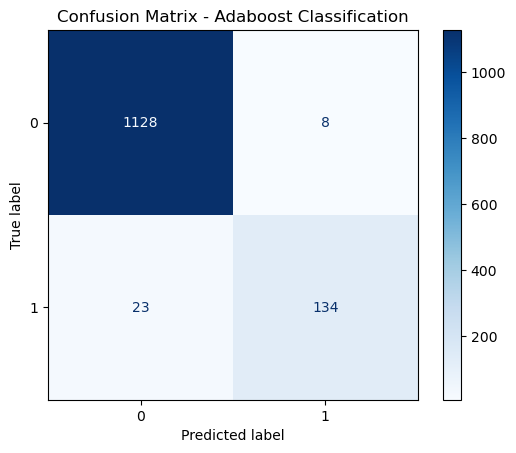

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If the target labels are in string format, perform label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Model fitting with the encoded target variable
model, name, feature, component, estimator_number, c00, c01, c10, c11, score, trainScore = Fit(
    AdaBoostClassifier(n_estimators=200, learning_rate=0.9),
    'Adaboost Classification',
    docs_train,
    docs_test,
    y_train_encoded,
    y_test_encoded
)

# Print the confusion matrix components
print("Actual Ham - Predicted Ham:", c00)
print("Actual Ham - Predicted Spam:", c01)
print("Actual Spam - Predicted Ham:", c10)
print("Actual Spam - Predicted Spam:", c11)
#print(classification_report(y_test, y_pred)) 

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, model.predict(docs_test))

# Evaluate the model
print(classification_report(y_test_encoded, model.predict(docs_test)))
print("test set")     
        
print("\Accuracy Score: " + str(metrics.accuracy_score(y_test_encoded, model.predict(docs_test))))
print("f1 Score: " + str(metrics.f1_score(y_test_encoded, model.predict(docs_test))))
print("Recall: " + str(metrics.recall_score(y_test_encoded, model.predict(docs_test))))
print("Precision: " + str(metrics.precision_score(y_test_encoded, model.predict(docs_test))))

# print("Confusion Matrix for Train : \n", confusion_matrix(y_train, y_train_pred))
# print("Accuracy Score for Train : ", accuracy_score(y_train, y_train_pred))
# print("ROC AUC for Train : ", roc_auc_score(y_train, y_train_prob))

# Create a ConfusionMatrixDisplay object for visualization
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

class_names = ['ham', 'spam']
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - ' + name)
plt.show()


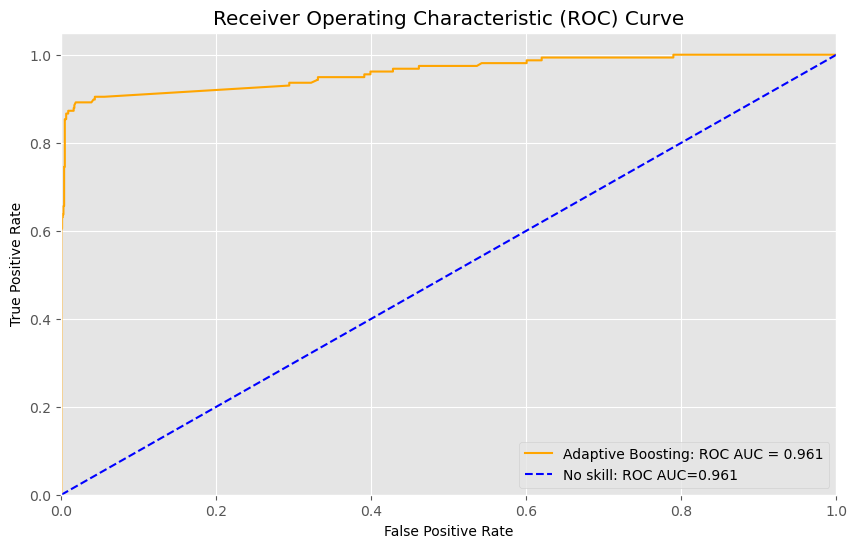

In [18]:
plt.style.use('ggplot')  # You can replace 'ggplot' with any available style name you prefer.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier

# Fit the AdaBoost model
model = AdaBoostClassifier(n_estimators=200, learning_rate=0.9)
model.fit(docs_train, y_train_encoded)

# Calculate probabilities for the positive class
y_prob = model.predict_proba(docs_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
# plt.figure()
plt.figure(figsize=(10, 6))
# ax.plot(fpr, tpr, color='orange', label='Random Forest: ROC AUC=%.3f' % (rf_auc))
plt.plot(fpr, tpr, color='orange', label='Adaptive Boosting: ROC AUC = %.3f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='No skill: ROC AUC=%.3f' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [19]:
df.isnull().sum()

category    0
text        0
spam        0
dtype: int64

In [20]:
X = df.iloc[:,1:3001]
y = df.iloc[:,-1].values
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=5)
#docs_train, docs_test, y_train, y_test = train_test_split(corpus_vec, Response_array, test_size = 0.25)

In [21]:
print(df.columns)


Index(['category', 'text', 'spam'], dtype='object')


In [22]:
# Random Forest Classifier

# Split the data into train and test sets
docs_train, docs_test, y_train, y_test = train_test_split(corpus_vec, Response_array, test_size = 0.25)
# X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
rfc = RandomForestClassifier(random_state=4)
rfc.fit(docs_train, y_train)

print("Train Results \n")
y_train_pred  = rfc.predict(docs_train)
y_train_prob = rfc.predict_proba(docs_train)[:,1]

print("Confusion Matrix for Train : \n", confusion_matrix(y_train, y_train_pred))
print("Accuracy Score for Train : ", accuracy_score(y_train, y_train_pred))
print("ROC AUC for Train : ", roc_auc_score(y_train, y_train_prob))

print("+"*50)
print("Test Results \n")
y_test_pred  = rfc.predict(docs_test)
y_test_prob = rfc.predict_proba(docs_test)[:,1]

print("Confusion Matrix for Test : \n", confusion_matrix(y_test, y_test_pred))
print("Accuracy Score for Test : ", accuracy_score(y_test, y_test_pred))
print("ROC AUC for Test : ", roc_auc_score(y_test, y_test_prob))

Train Results 

Confusion Matrix for Train : 
 [[3371    0]
 [   4  501]]
Accuracy Score for Train :  0.9989680082559339
ROC AUC for Train :  0.999171148203518
++++++++++++++++++++++++++++++++++++++++++++++++++
Test Results 

Confusion Matrix for Test : 
 [[1138    7]
 [  21  127]]
Accuracy Score for Test :  0.9783449342614076
ROC AUC for Test :  0.9889295408946064


Train Results 

Confusion Matrix for Train : 
 [[3371    0]
 [   4  501]]
Accuracy Score for Train :  0.9989680082559339
ROC AUC for Train :  0.999171148203518


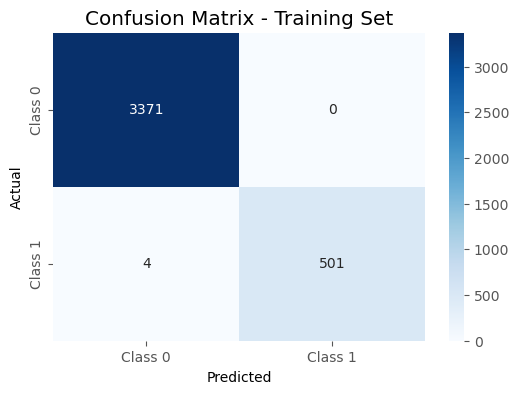

++++++++++++++++++++++++++++++++++++++++++++++++++
Test Results 

Confusion Matrix for Test : 
 [[1138    7]
 [  21  127]]
Accuracy Score for Test :  0.9783449342614076
ROC AUC for Test :  0.9889295408946064


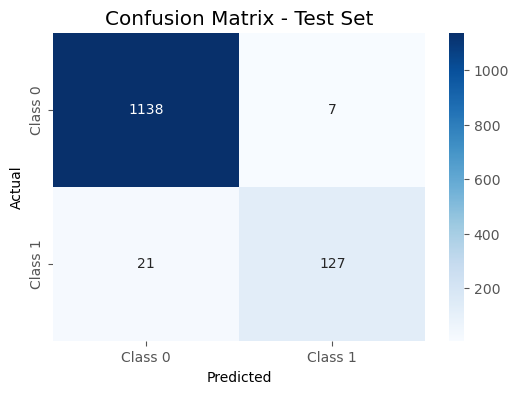

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# Assuming you have defined rfc, docs_train, y_train, docs_test, and y_test

# Train Set
print("Train Results \n")
y_train_pred = rfc.predict(docs_train)
y_train_prob = rfc.predict_proba(docs_train)[:, 1]

print("Confusion Matrix for Train : \n", confusion_matrix(y_train, y_train_pred))
print("Accuracy Score for Train : ", accuracy_score(y_train, y_train_pred))
print("ROC AUC for Train : ", roc_auc_score(y_train, y_train_prob))

# Plot the confusion matrix for the training set
train_cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("+" * 50)

# Test Set
print("Test Results \n")
y_test_pred = rfc.predict(docs_test)
y_test_prob = rfc.predict_proba(docs_test)[:, 1]

print("Confusion Matrix for Test : \n", confusion_matrix(y_test, y_test_pred))
print("Accuracy Score for Test : ", accuracy_score(y_test, y_test_pred))
print("ROC AUC for Test : ", roc_auc_score(y_test, y_test_prob))

# Plot the confusion matrix for the test set
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [24]:
# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Assuming X_categorical contains your categorical columns
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(docs_train)


rfc = RandomForestClassifier(random_state=4)


params = {'n_estimators': sp_randint(50,400),
          'max_features' : sp_randint(2,16),
          'max_depth' : sp_randint(2,10),
          'min_samples_split' : sp_randint(2,25),
          'min_samples_leaf' : sp_randint(1,25),
          'criterion':['gini','entropy']}

rsearch = RandomizedSearchCV(rfc,
                             param_distributions=params,
                             n_iter=50,
                             cv=3, 
                             return_train_score = True,
                             scoring='roc_auc',
                             n_jobs=-1,
                            random_state=5)

rsearch.fit(corpus_vec, Response_array)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=4),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000115DA869D50>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000115DA868F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000115DA869720>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000115DA869900>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000115D44FB220>},
                   random_state=5, return_train_score=True, scoring='roc_auc')

In [25]:
rsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 13,
 'n_estimators': 221}

In [26]:
# Applying Best Params

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

rfc = RandomForestClassifier(**rsearch.best_params_,random_state=4,oob_score=True)
rfc.fit(docs_train,y_train)

docs_train, docs_test, y_train, y_test = train_test_split(corpus_vec, Response_array, test_size = 0.25)

print("Train Results \n")
y_train_pred  = rfc.predict(docs_train)
y_train_prob = rfc.predict_proba(docs_train)[:,1]

print("Confusion Matrix for Train : \n", confusion_matrix(y_train, y_train_pred))
print("Accuracy Score for Train : ", accuracy_score(y_train, y_train_pred))
print("ROC AUC for Train : ", roc_auc_score(y_train, y_train_prob))
print("OOB Score for Train : ", rfc.oob_score_)

print("+"*50)
print("Test Results \n")
y_test_pred  = rfc.predict(docs_test)
y_test_prob = rfc.predict_proba(docs_test)[:,1]

print("Confusion Matrix for Test : \n", confusion_matrix(y_test, y_test_pred))
print("Accuracy Score for Test : ", accuracy_score(y_test, y_test_pred))
print("ROC AUC for Test : ", roc_auc_score(y_test, y_test_prob))

Train Results 

Confusion Matrix for Train : 
 [[3379    0]
 [ 490    7]]
Accuracy Score for Train :  0.8735810113519091
ROC AUC for Train :  0.987345797186195
OOB Score for Train :  0.8710010319917441
++++++++++++++++++++++++++++++++++++++++++++++++++
Test Results 

Confusion Matrix for Test : 
 [[1137    0]
 [ 156    0]]
Accuracy Score for Test :  0.8793503480278422
ROC AUC for Test :  0.9723039713145254


In [27]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_prob)
thresholds[0] = thresholds[0]-1

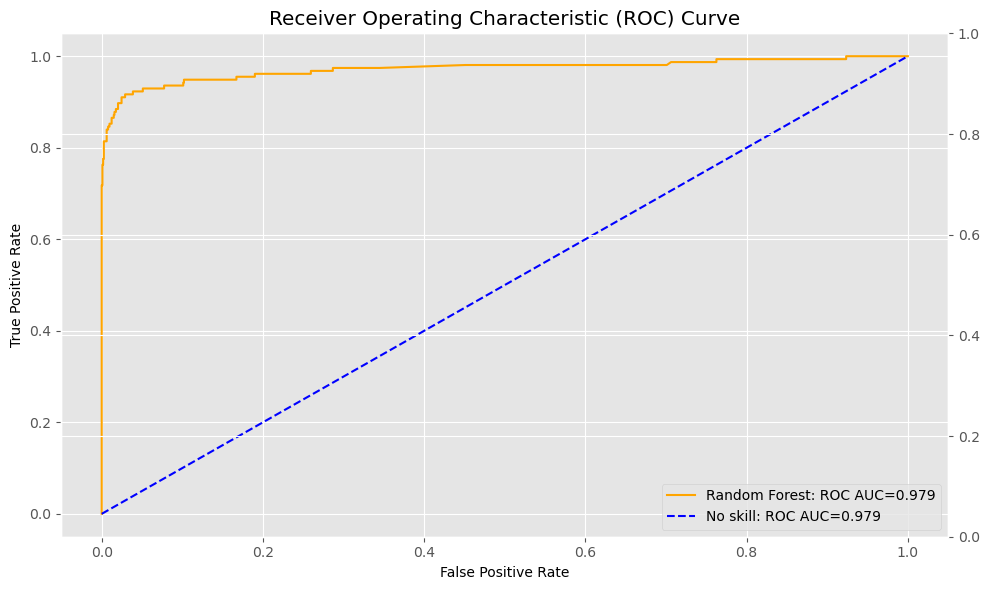

In [28]:
# ROC-AUC Curve for Test Data

plt.style.use('ggplot')  # You can replace 'ggplot' with any available style name you prefer.
#plt.style.use('default')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import io

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model with your desired hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, random_state=4)  # You can adjust the hyperparameters

# Fit your Random Forest model on the training data
rf_model.fit(docs_train, y_train)

# Predict probabilities on the test data
rf_probs = rf_model.predict_proba(docs_test)[:, 1]


# import numpy as np

# # Define 'No Skill' probabilities where both classes are equally likely
# ns_probs = np.linspace(0, 1, num=len(y_test))

# # Calculate the ROC AUC score for the 'No Skill' model
# ns_auc = roc_auc_score(y_test, ns_probs)



# Calculate the ROC AUC score for the Random Forest model
rf_auc = roc_auc_score(y_test, rf_probs)
ns_auc = roc_auc_score(y_test, rf_probs)


# Fit your Random Forest model on the training data
rf_model.fit(docs_train, y_train)

# Predict probabilities on the test data
rf_probs = rf_model.predict_proba(docs_test)[:, 1]

# Calculate the ROC AUC score for the Random Forest model
rf_auc = roc_auc_score(y_test, rf_probs)


# Assuming you have defined fpr, tpr, threshold

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fpr, tpr, color='orange', label='Random Forest: ROC AUC=%.3f' % (rf_auc))
ax.plot(fpr, fpr, color='blue', linestyle='--', label='No skill: ROC AUC=%.3f' % (ns_auc))

# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No skill: ROC AUC=%.3f' % (ns_auc))
# plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM: ROC AUC=%.3f' % (lr_auc))


ax1 = ax.twinx()
# ax1.plot(fpr, thresholds, color='blue', label='Thresholds')

ax.set_title("Receiver Operating Characteristic (ROC) Curve")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax1.set_ylabel('Thresholds')

fig.tight_layout()

# Combine the legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')

plt.show()



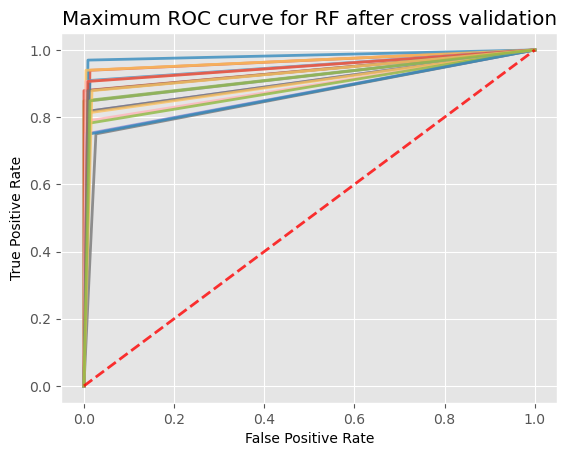

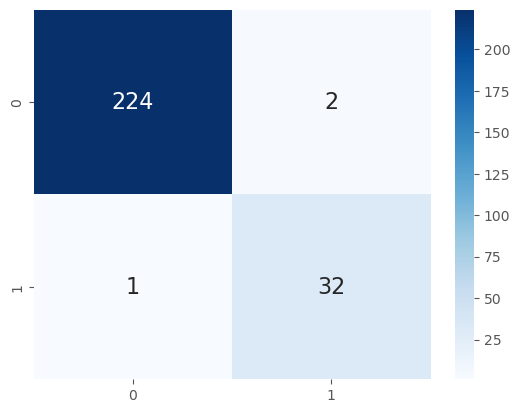

'Max_Accuracy : 0.9884%'

In [38]:
# Import the required libraries
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import RocCurveDisplay

# Define the function cross_validate_Model
def cross_validate_Model(classifier, X, y, choice):
    # Variables
    cv = StratifiedKFold(n_splits=20)
    mean_fpr = np.linspace(0, 1, 100)
    # Lists to store results
    tprs = []
    aucs = []
    class_repo_lst = []
    acc_repo = []
    conv_lst = []
    accruacy_scores_lst = []

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        training_data = X[train]
        testing_data = X[test]

        classifier.fit(training_data, y[train])
        y_pred = classifier.predict(testing_data)
        accruacy_scores_lst.append(accuracy_score(y[test], y_pred))
        
        repo = classification_report(y[test], y_pred, target_names=['Ham', 'Spam'])
        class_repo_lst.append(repo)
        acc_repo.append(float(repo[203:207]))
        indx = acc_repo.index(max(acc_repo))

        if choice == 'c':
            conv_lst.append(confusion_matrix(y[test], y_pred))

        if choice == 'r':
            fpr, tpr, _ = roc_curve(y[test], y_pred)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, alpha=.8)
            aucs.append(roc_auc)

    if choice == 'r':
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        ax.set(title="Maximum ROC curve for RF after cross validation")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        plt.show()
        
#         # Plotting ROC
#         ax.plot(mean_fpr, mean_auc, color='b', lw=2, alpha=.8)

#         print(class_repo_lst[indx])
            
#         class_names = ['ham', 'spam']

    if choice == 'c':
        conv = conv_lst[indx]
        sns.heatmap(conv, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
        plt.show()

    class_repo_lst.clear()
    acc_repo.clear()
    conv_lst.clear()

    return "Max_Accuracy : " + str(round(np.array(accruacy_scores_lst).max(), 4)) + "%"

# Call the function for AdaBoost
cross_validate_Model(AdaBoostClassifier(n_estimators=200, learning_rate=0.9), corpus_vec, Response_array, 'r')

cross_validate_Model(AdaBoostClassifier(n_estimators=200, learning_rate=0.9), corpus_vec, Response_array, 'c')

# # Call the function for Random Forest
# cross_validate_Model(RandomForestClassifier(random_state=4), corpus_vec, Response_array, 'r')

# cross_validate_Model(RandomForestClassifier(random_state=4), corpus_vec, Response_array, 'c')


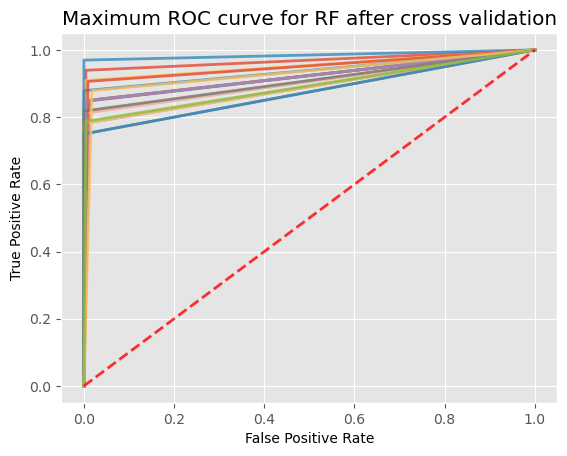

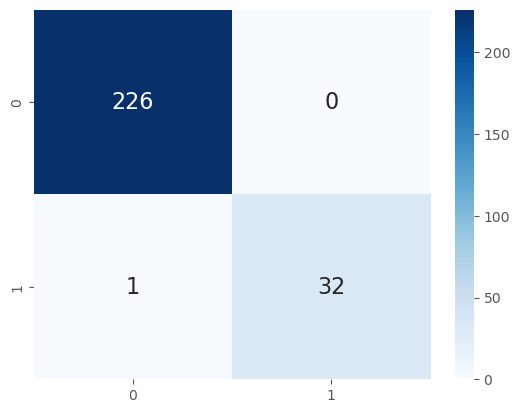

'Max_Accuracy : 0.9961%'

In [39]:
# Call the function for Random Forest
cross_validate_Model(RandomForestClassifier(random_state=4), corpus_vec, Response_array, 'r')

cross_validate_Model(RandomForestClassifier(random_state=4), corpus_vec, Response_array, 'c')

In [ ]:
# Import the required libraries
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import RocCurveDisplay

# Define the function cross_validate_Model
def cross_validate_Model(classifier, choice):    
    # Data
    X = np.array(df["corpus_vec"])
    y = np.array(df['Response_array'])
    X, y = X[y != 2], y[y != 2]
    # Variables
    cv = StratifiedKFold(n_splits=20)
    mean_fpr = np.linspace(0, 1, 100)
    # Lists to store results
    tprs = []
    aucs = []
    class_repo_lst = []
    acc_repo = []
    conv_lst = []
    accruacy_scores_lst = []

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        training_data = vec.fit_transform(X[train])
        testing_data = vec.transform(X[test])

        classifier.fit(training_data, y[train])
        y_pred = classifier.predict(testing_data)
        accruacy_scores_lst.append(accuracy_score(y[test], y_pred))
        
        repo = classification_report(y[test], y_pred, target_names=['Ham', 'Spam'])
        class_repo_lst.append(repo)
        acc_repo.append(float(repo[203:207]))
        indx = acc_repo.index(max(acc_repo))

        if choice == 'c':
            conv_lst.append(confusion_matrix(y[test], y_pred))

        if choice == 'r':
            fpr, tpr, _ = roc_curve(y[test], y_pred)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, alpha=.8)
            aucs.append(roc_auc)

    if choice == 'r':
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        ax.set(title="Maximum ROC curve after cross validation")
        plt.show()

    if choice == 'c':
        conv = conv_lst[indx]
        sns.heatmap(conv, annot=True, annot_kws={"size": 16})
        plt.show()

    class_repo_lst.clear()
    acc_repo.clear()
    conv_lst.clear()

    return "Max_Accuracy : " + str(round(np.array(accruacy_scores_lst).max(), 4)) + "%"

# Call the function for AdaBoost
cross_validate_Model(AdaBoostClassifier(n_estimators=200, learning_rate=0.9), 'r')

cross_validate_Model(AdaBoostClassifier(n_estimators=200, learning_rate=0.9), 'c')

# Call the function for Random Forest
cross_validate_Model(RandomForestClassifier(random_state=4), 'r')

cross_validate_Model(RandomForestClassifier(random_state=4), 'c')

In [ ]:
# Import the required libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, plot_roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

# Define the function cross_validate_Model
def cross_validate_Model(classifier, choice):
    # Data
    X = np.array(data_under["pre_pro_doc"])
    y = np.array(data_under['class'])
    X, y = X[y != 2], y[y != 2]
    # Variables
    cv = StratifiedKFold(n_splits=20)
    mean_fpr = np.linspace(0, 1, 100)
    # Lists to store results
    tprs = []
    aucs = []
    class_repo_lst = []
    acc_repo = []
    conv_lst = []
    accruacy_scores_lst = []

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cv.split(X, y)):
        training_data = vec.fit_transform(X[train])
        testing_data = vec.transform(X[test])

        classifier.fit(training_data, y[train])
        y_pred = classifier.predict(testing_data)
        accruacy_scores_lst.append(accuracy_score(y[test], y_pred))
        
        repo = classification_report(y[test], y_pred, target_names=['Ham', 'Spam'])
        class_repo_lst.append(repo)
        acc_repo.append(float(repo[203:207]))
        indx = acc_repo.index(max(acc_repo))

        if choice == 'c':
            conv_lst.append(confusion_matrix(y[test], y_pred))

        if choice == 'r':
            viz = plot_roc_curve(classifier, testing_data, y[test], name="", alpha=0.3, lw=1, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

    if choice == 'r':
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        mean_tpr = np.max(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=.8)
        print(class_repo_lst[indx])

    if choice == 'c':
        conv = conv_lst[indx]
        sns.heatmap(conv, annot=True, annot_kws={"size": 16})
        plt.show()

    if choice == 'r':
        ax.set(title="Maximum ROC curve after cross validation")
        ax.get_legend().remove()
        plt.show()

    class_repo_lst.clear()
    acc_repo.clear()
    conv_lst.clear()

    return "Max_Accuracy : " + str(round(np.array(accruacy_scores_lst).max(), 4)) + "%"

# Call the function for AdaBoost
cross_validate_Model(AdaBoostClassifier(n_estimators=200, learning_rate=0.9), 'r')

cross_validate_Model(AdaBoostClassifier(n_estimators=200, learning_rate=0.9), 'c')

# Call the function for Random Forest
cross_validate_Model(RandomForestClassifier(random_state=4), 'r')

cross_validate_Model(RandomForestClassifier(random_state=4), 'c')

In [ ]:
# # set random_state

# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=8888)
# cv_accuracy_results = []
# cv_auc_results = []
# cv_recall_results = []
# cv_f1_results = []

# for classifier in classifiers:
#     cv_accuracy_results.append(cross_val_score(classifier, train_X, y = train_y, scoring = "accuracy", cv = kfold))
#     cv_auc_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'roc_auc', cv = kfold))
#     cv_recall_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'recall', cv = kfold))
#     cv_f1_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'f1', cv = kfold))
    

# cv_accuracy_means = []
# cv_auc_means = []
# cv_recall_means = []
# cv_f1_means = []

# for fold in range(5):
#     cv_accuracy_means.append(cv_accuracy_results[fold].mean())
#     cv_auc_means.append(cv_auc_results[fold].mean())
#     cv_recall_means.append(cv_recall_results[fold].mean())
#     cv_f1_means.append(cv_f1_results[fold].mean())

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Assuming the last column contains the target labels (spam or not spam)
# X = df.iloc[:, :-1]  # Features
# y = df.iloc[:, -1]   # Target labels

# # Encode string labels into numeric labels
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# # Encode categorical features
# for col in X.select_dtypes(include=['object']):
#     X[col] = label_encoder.fit_transform(X[col])

# # Define the number of splits (k)
# n_splits = 5

# # Initialize StratifiedKFold with desired number of splits
# stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize an empty list to store accuracy scores
# accuracy_scores = []

# # Iterate through the splits
# for fold_idx, (train_indices, test_indices) in enumerate(stratified_kfold.split(X, y)):
#     print(f"Fold {fold_idx + 1}:")
    
#     # Get the training and test data for this fold
#     X_train_fold, X_test_fold = X.iloc[train_indices], X.iloc[test_indices]
#     y_train_fold, y_test_fold = y[train_indices], y[test_indices]
    
#     # Initialize RandomForestClassifier
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
    
#     # Train the model
#     model.fit(X_train_fold, y_train_fold)
    
#     # Make predictions on the test data
#     y_pred = model.predict(X_test_fold)
    
#     # Calculate accuracy for this fold
#     accuracy = accuracy_score(y_test_fold, y_pred)
#     print(f"Accuracy: {accuracy}")
    
#     # Store accuracy for this fold
#     accuracy_scores.append(accuracy)

# # Calculate and print the average accuracy across all folds
# average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
# print(f"Average Accuracy: {average_accuracy}")
